In [1]:
!pip install tensorflow numpy matplotlib seaborn scikit-learn gradio pillow pandas opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations

In [3]:
testpath= r'C:\Users\Sailesh\OneDrive - vit.ac.in\Documents\AICTE\modified-dataset\test'
trainpath= r'C:\Users\Sailesh\OneDrive - vit.ac.in\Documents\AICTE\modified-dataset\train'
validpath = r'C:\Users\Sailesh\OneDrive - vit.ac.in\Documents\AICTE\modified-dataset\val'

In [4]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [5]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [6]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [7]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


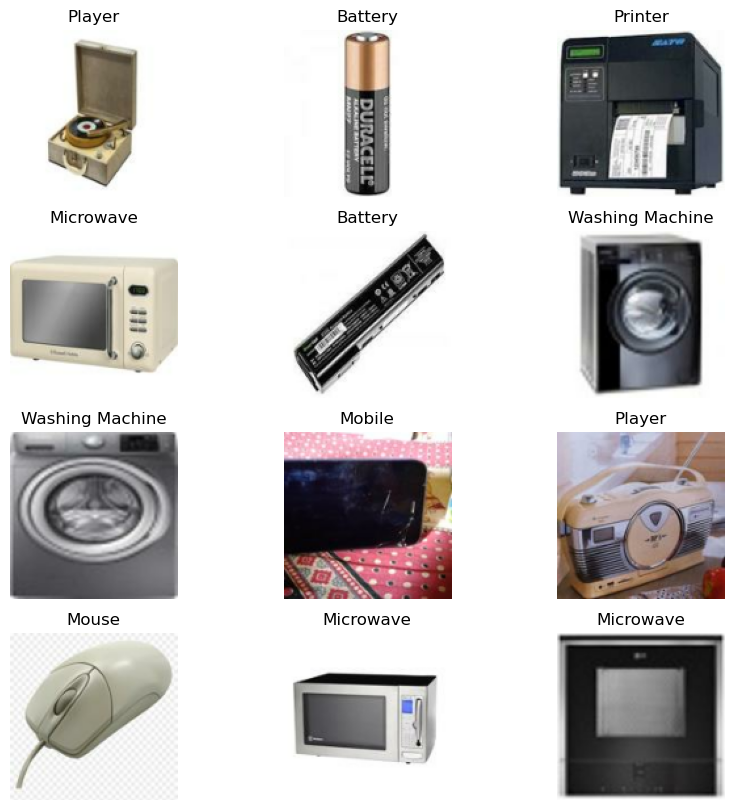

In [8]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

In [9]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class

    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot

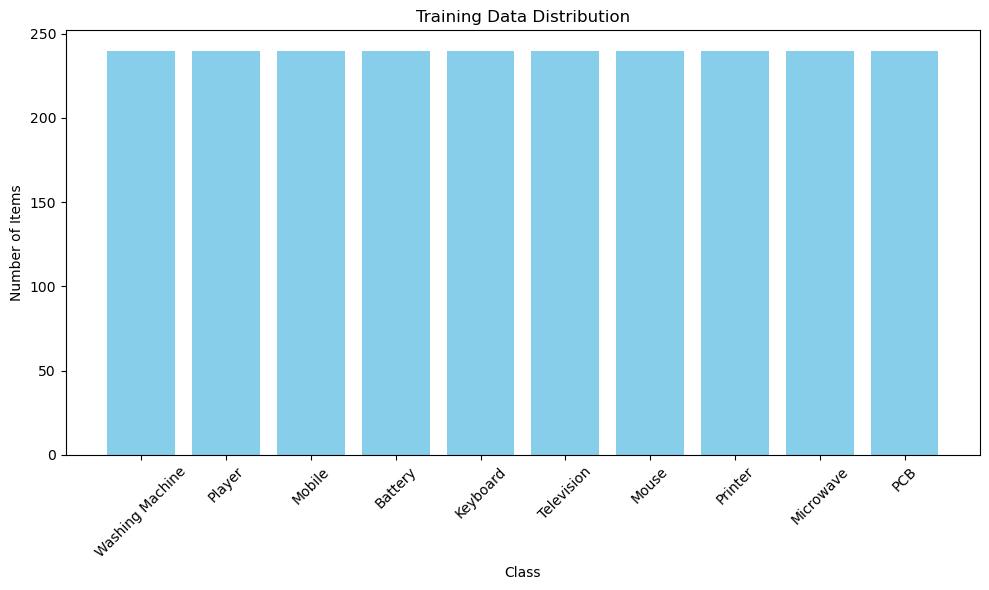

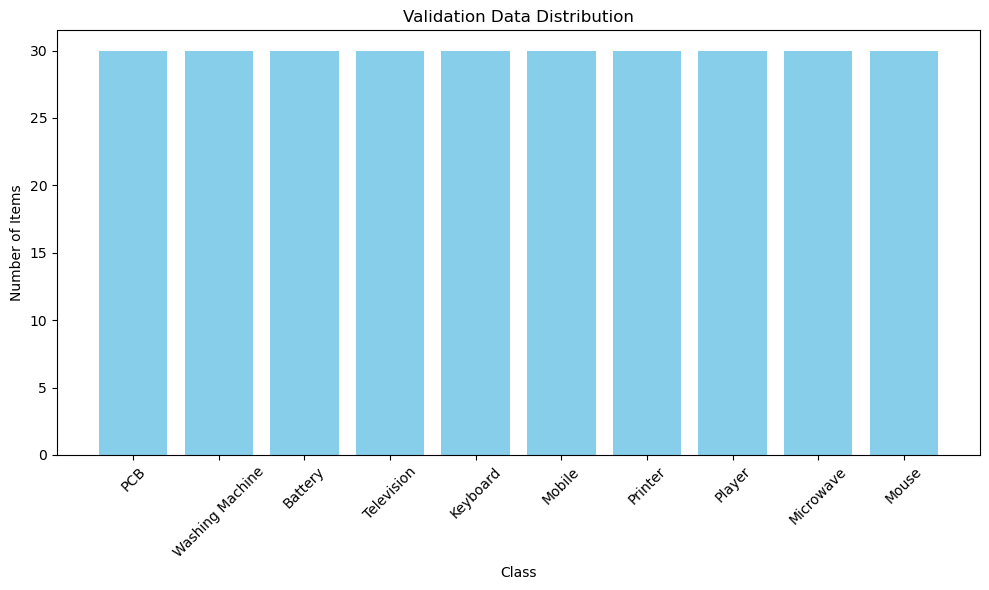

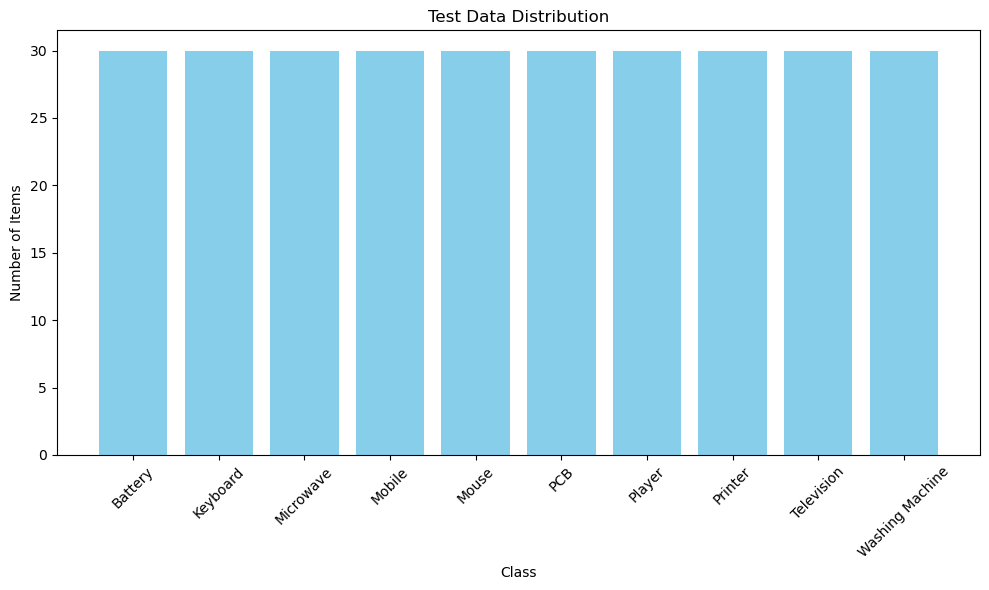

In [10]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [12]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [14]:
import tensorflow as tf

# Define data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Define base model (example using MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['Accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

datatrain = train_datagen.flow_from_directory(
    r'C:\Users\Sailesh\OneDrive - vit.ac.in\Documents\AICTE\modified-dataset\train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

datavalid = valid_datagen.flow_from_directory(
    r'C:\Users\Sailesh\OneDrive - vit.ac.in\Documents\AICTE\modified-dataset\val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [26]:
epochs = 15

history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=epochs,
    batch_size=100,
    callbacks=[early]
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 334ms/step - Accuracy: 0.2830 - loss: 2.2823 - val_Accuracy: 0.6267 - val_loss: 1.1914
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - Accuracy: 0.5841 - loss: 1.2531 - val_Accuracy: 0.7533 - val_loss: 0.8306
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - Accuracy: 0.6835 - loss: 0.9739 - val_Accuracy: 0.8100 - val_loss: 0.6721
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - Accuracy: 0.7442 - loss: 0.8146 - val_Accuracy: 0.8300 - val_loss: 0.5754
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - Accuracy: 0.7585 - loss: 0.7602 - val_Accuracy: 0.8433 - val_loss: 0.5130
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - Accuracy: 0.7683 - loss: 0.7130 - val_Accuracy: 0.8700 - val_loss: 0.4617
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 290ms/step - Accuracy: 0.7941 - loss: 0.6370 - val_Accuracy: 0.8800 - val_loss: 0.4263
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 298ms/step - Accuracy: 0.7912 - loss: 0.6461 - val_Accu

In [27]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,296,416 (8.76 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 25,622 (100.09 KB)

In [28]:
base_model.summary() # Print the architecture summary of the base model

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

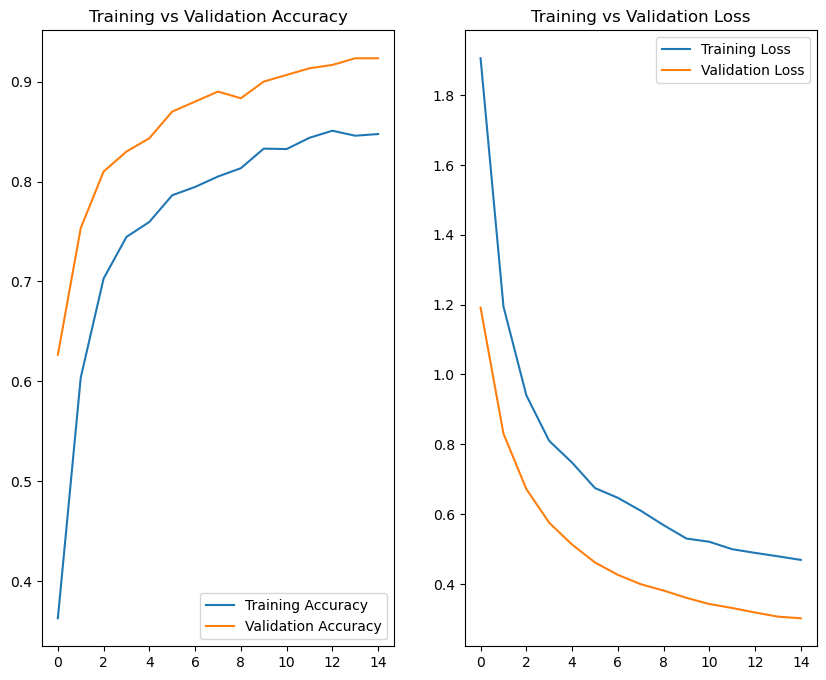

In [29]:
import matplotlib.pyplot as plt  # <-- Add this line before plotting

acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test dataset
datatest = test_datagen.flow_from_directory(
    r'C:\Users\Sailesh\OneDrive - vit.ac.in\Documents\AICTE\modified-dataset\test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Evaluate model on test dataset
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')

Found 300 images belonging to 10 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - Accuracy: 0.8282 - loss: 0.4608
Test accuracy is 0.8733, Test loss is 0.3784


In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Extract true labels from test data
y_true = datatest.classes  # True labels from the DirectoryIterator

# Get predicted probabilities
y_pred_probs = model.predict(datatest)

# Get predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Show results
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step
Confusion Matrix:
[[20  0  0  1  0  2  5  0  0  2]
 [ 2 27  0  0  0  0  1  0  0  0]
 [ 0  0 25  0  0  0  1  1  3  0]
 [ 1  0  0 25  0  3  1  0  0  0]
 [ 1  0  0  0 28  0  1  0  0  0]
 [ 1  0  0  0  0 28  1  0  0  0]
 [ 1  0  0  0  0  0 28  0  0  1]
 [ 0  0  0  0  0  0  4 26  0  0]
 [ 0  0  2  0  0  0  2  0 26  0]
 [ 1  0  0  0  0  0  0  0  0 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        30
           1       1.00      0.90      0.95        30
           2       0.93      0.83      0.88        30
           3       0.96      0.83      0.89        30
           4       1.00      0.93      0.97        30
           5       0.85      0.93      0.89        30
           6       0.64      0.93      0.76        30
           7       0.96      0.87      0.91        30
           8       0.90      0.87      0.88        30
           9       0.91      0.97      0.94  

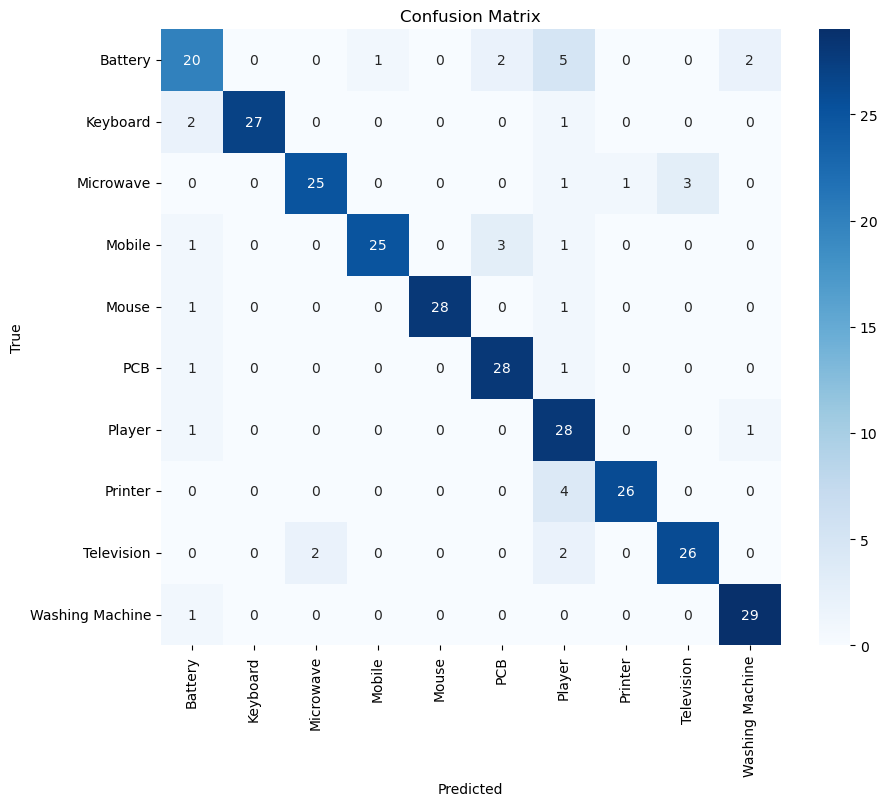

In [33]:
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names from datatest
class_names = list(datatest.class_indices.keys())

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()